# NetCDF reading and writing

## Read from one netCDF file

In [1]:
from dimarray import read_nc, get_datadir
import os
ncfile = os.path.join(get_datadir(), 'cmip5.CSIRO-Mk3-6-0.nc')  # get one netCDF file
data = read_nc(ncfile)  # load full file
data

Dataset of 2 variables
0 / time (451): 1850 to 2300
1 / scenario (5): u'historical' to u'rcp85'
tsl: (u'time', u'scenario')
temp: (u'time', u'scenario')

Then access the variable of choice

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


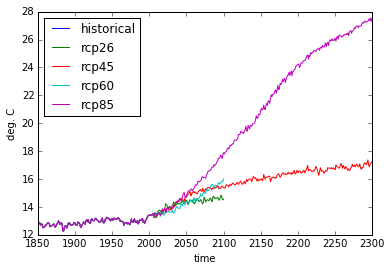

In [2]:
%pylab
%matplotlib inline  
_ = data['temp'].plot()
_ = plt.legend(loc='upper left') # doctest: +SKIP

Load only one variable

In [3]:
data = read_nc(ncfile,'temp') # only one variable
data = read_nc(ncfile,'temp', indices={"time":slice(2000,2100), "scenario":"rcp45"})  # load only a chunck of the data
data = read_nc(ncfile,'temp', indices={"time":1950.3}, tol=0.5)  #  approximate matching, adjust tolerance
data = read_nc(ncfile,'temp', indices={"time":-1}, indexing='position')  #  integer position indexing

##  Read from multiple files

Read variable 'temp' across multiple files (representing various climate models). 
In this case the variable is a time series, whose length may vary across experiments 
(thus align=True is passed to reindex axes before stacking). Under the hood the function 
py:func:`dimarray.stack` is called:

In [4]:
direc = get_datadir()
temp = read_nc(direc+'/cmip5.*.nc', 'temp', align=True, axis='model')

A new 'model' axis is created labeled with file names. It is then 
possible to rename it more appropriately, e.g. keeping only the part
directly relevant to identify the experiment:

In [5]:
getmodel = lambda x: os.path.basename(x).split('.')[1] # extract model name from path
temp.set_axis(getmodel, axis='model', inplace=True) # would return a copy if inplace is not specified
temp

dimarray: 9114 non-null elements (6671 null)
0 / model (7): 'CSIRO-Mk3-6-0' to 'MPI-ESM-MR'
1 / time (451): 1850 to 2300
2 / scenario (5): u'historical' to u'rcp85'
array(...)

This works on datasets as well

In [6]:
ds = read_nc(direc+'/cmip5.*.nc', align=True, axis='model')
ds.set_axis(getmodel, axis='model', inplace=True)
ds

Dataset of 2 variables
0 / model (7): 'CSIRO-Mk3-6-0' to 'MPI-ESM-MR'
1 / time (451): 1850 to 2300
2 / scenario (5): u'historical' to u'rcp85'
tsl: ('model', u'time', u'scenario')
temp: ('model', u'time', u'scenario')

## Write to netCDF 

Let's define some dummy arrays representing temperature in northern and southern hemisphere for three years.

In [7]:
from dimarray import DimArray
temperature = DimArray([[1.,2,3], [4,5,6]], axes=[['north','south'], [1951, 1952, 1953]], dims=['lat', 'time'])
global_mean = temperature.mean(axis='lat')  
climatology = temperature.mean(axis='time')

Let's define a new dataset

In [8]:
from dimarray import Dataset
ds = Dataset({'temperature':temperature, 'global':global_mean})
ds

Dataset of 2 variables
0 / time (3): 1951 to 1953
1 / lat (2): 'north' to 'south'
global: ('time',)
temperature: ('lat', 'time')

Saving the dataset to file is pretty simple:

In [9]:
ds.write_nc('/tmp/test.nc', mode='w')

It is possible to append more variables

In [10]:
climatology.write_nc('/tmp/test.nc', 'climatology', mode='a')  # by default mode='w'

Just as a check, all three variables seem to be there:

In [11]:
read_nc('/tmp/test.nc')

Dataset of 3 variables
0 / time (3): 1951 to 1953
1 / lat (2): u'north' to u'south'
global: (u'time',)
temperature: (u'lat', u'time')
climatology: (u'lat',)

Note that when appending a variable to a netCDF file or to a dataset, its axes must match, otherwise an error will be raised. In that case it may be necessary to reindex an axis (see :ref:`page_reindexing`). When initializing a dataset with bunch of dimarray however, reindexing is performed automatically.

## New NetCDF4 storage

.. versionadded :: 0.2

Since version 0.2, the methods above are a wrapper around :class:dimarray.DatasetOnDisk class, which allows lower level access with a DimArray feeling.

In [12]:
import dimarray as da
import numpy as np
dima = da.DimArray([[1,2,3],[4,5,6]], axes=[('time',[2000,2045.5]),('scenario',['a','b','c'])])
dima.units = 'myunits' # metadata 
dima.axes['time'].units = 'metadata-dim-in-memory'

ds = da.open_nc('/tmp/test.nc', mode='w')
ds['myvar'] = dima
ds['myvar'].bla = 'bla'
ds['myvar'].axes['time'].yo = 'metadata-dim-on-disk'
ds.axes['scenario'].ya = 'metadata-var-on-disk'
ds.yi = 'metadata-dataset-on-disk'
ds.close()

Let's check the result:

In [13]:
ds2 = da.open_nc("/tmp/test.nc", mode="a")
ds2

DatasetOnDisk of 1 variable (NETCDF4)
0 / time (2): 2000.0 to 2045.5
1 / scenario (3): u'a' to u'c'
myvar: (u'time', u'scenario')

In [14]:
ds2.summary()

DatasetOnDisk of 1 variable (NETCDF4)

//dimensions:
0 / time (2): 2000.0 to 2045.5
    units: u'metadata-dim-in-memory'
    yo: u'metadata-dim-on-disk'
1 / scenario (3): u'a' to u'c'
    ya: u'metadata-var-on-disk'

//variables:
myvar: (u'time', u'scenario')
    units: u'myunits'
    bla: u'bla'

//global attributes:
    yi: u'metadata-dataset-on-disk'


In [15]:
ds2['myvar']

DimArrayOnDisk: 'myvar' (6)
0 / time (2): 2000.0 to 2045.5
1 / scenario (3): u'a' to u'c'

In [16]:
ds2['myvar'].values  # doctest: +SKIP

<type 'netCDF4._netCDF4.Variable'>
int64 myvar(time, scenario)
    units: myunits
    bla: bla
unlimited dimensions: 
current shape = (2, 3)
filling on, default _FillValue of -9223372036854775806 used

In [17]:
ds2['myvar'][:]

dimarray: 6 non-null elements (0 null)
0 / time (2): 2000.0 to 2045.5
1 / scenario (3): u'a' to u'c'
array([[1, 2, 3],
       [4, 5, 6]])

In [18]:
ds2['myvar'][2000, 'b'] = 77
ds2['myvar'][:]

dimarray: 6 non-null elements (0 null)
0 / time (2): 2000.0 to 2045.5
1 / scenario (3): u'a' to u'c'
array([[ 1, 77,  3],
       [ 4,  5,  6]])

In [19]:
ds2['myvar'].ix[0, -1] = -1
ds2['myvar'][:]

dimarray: 6 non-null elements (0 null)
0 / time (2): 2000.0 to 2045.5
1 / scenario (3): u'a' to u'c'
array([[ 1, 77, -1],
       [ 4,  5,  6]])

In [20]:
ds2.close()

### Create a variable with unlimited dimension

In [21]:
import dimarray as da

ds = da.open_nc('/tmp/test.nc', 'w')
ds.axes.append('time', None)
ds.nc.dimensions['time']  # underlying netCDF4 object  # doctest: +SKIP

<type 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 0

Fill-up the variable:

In [22]:
ds['bla'] = da.DimArray([1,2,3,4,5], dims=['time'], axes=[list('abcde')])
ds.nc.dimensions['time'] # underlying netCDF4 object   # doctest: +SKIP

<type 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 5

Append some new slices:

In [23]:
ds['bla'].ix[5] = da.DimArray([66], dims=['time'], axes=[['f']])
ds.nc.dimensions['time'] # underlying netCDF4 object    # doctest: +SKIP

<type 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 6

In [24]:
ds['bla'].read()

dimarray: 6 non-null elements (0 null)
0 / time (6): u'a' to u'f'
array([ 1,  2,  3,  4,  5, 66])

In [25]:
ds.close()